In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')


In [2]:
from IPython.display import HTML, Image

In [3]:
from timeit import default_timer as timer

Massively parallel programming with GPUs
===

In [4]:
Image(url='http://www.nvidia.com/docs/IO/143716/cpu-and-gpu.jpg')

In [5]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/-P28LKWTzrI" frameborder="0" allowfullscreen></iframe>')

In [6]:
Image(url='http://www.nvidia.com/docs/IO/143716/how-gpu-acceleration-works.png')

Programming GPUs
----

CUDA
    - C/C++
    - Fortran
    - Python 
OpenCL
    - C/C++

On GPUs, they both offer about the same level of performance. For sceintific workflows, they are probably also equivalent. OpenCL is supported by multiple vendors - NVidia, AMD, Intel IBM, ARM, Qualcomm etc, while CUDA is only supported by NVidia.

Currently, only CUDA supports direct compilation of code targeting the GPU from Python (via the Anaconda accelerate compiler), although there are also wrappers for both CUDA and OpenCL (using Python to generate C code for compilation). In any case, it will certainly be easier to learn OpenCL if you have programmed in CUDA since they are very similar.

GPU Architecture
----

#### CPU veruss GPU

A CPU is designed to handle complex tasks - time sliciing, virtual machine emulation, complex control flows and branching, security etc. In contrast, GPUs only do one thing well - handle billions of repetitive low level tasks - originally the rendering of triangles in 3D graphics, and they have thousands of ALUs as compared with the CPUs 4 or 8.. Many scientific prgorams spend most of their time doing just what GPUs are good for - handle billions of repetitive low level tasks - and hence the fidle of GPU computing was born.

Originally, this was called GPCPU (General Purpose GPU programming), and it required mapping scientific code to the matrix operations for manipulating traingles. This was insanely difficult to do and took a lot of dedication. However, with the advent of CUDA and OpenCL, high-level langagues targeting the GPU, GPU programming is rapidly becoming mainstream in the scientific community.  

In [7]:
Image(url='http://www.frontiersin.org/files/Articles/70265/fgene-04-00266-HTML/image_m/fgene-04-00266-g001.jpg')

#### Inside a GPU

In [8]:
Image(url='http://www.orangeowlsolutions.com/wp-content/uploads/2013/03/Fig1.png')

#### The streaming multiprocessor

In [9]:
Image(url='http://www.orangeowlsolutions.com/wp-content/uploads/2013/03/Fig2.png')

#### The CUDA Core

In [10]:
Image(url='http://www.orangeowlsolutions.com/wp-content/uploads/2013/03/Fig3.png')

#### Memory Hiearchy

In [11]:
Image(url='http://www.orangeowlsolutions.com/wp-content/uploads/2013/03/Fig9.png')

#### Processing flow

In [12]:
Image(url='http://upload.wikimedia.org/wikipedia/commons/thumb/5/59/CUDA_processing_flow_%28En%29.PNG/450px-CUDA_processing_flow_%28En%29.PNG')

#### CUDA Kernels

In [13]:
Image(url='http://www.biomedcentral.com/content/supplementary/1756-0500-2-73-s2.png')

#### CUDA execution model

In [14]:
Image(url='http://3dgep.com/wp-content/uploads/2011/11/Cuda-Execution-Model.png')

#### CUDA threads

In [15]:
Image(url="http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/grid-of-thread-blocks.png")

#### Memoery access levels

In [16]:
Image(url='http://docs.nvidia.com/cuda/parallel-thread-execution/graphics/memory-hierarchy.png')

### Recap of CUDA Jargon and Concepts

#### Generations

- Tesla (Compute Capability 1)
- Fermi (Compute Capability 2)
- Kepler (Compute Capability 3)
- Maxwell (current generation - Compute Capability 5)
- Pascal (next generation - not in production yet)

Confusingly, Tesla is also the brand name for NVidia's GPGPU line of cards as well as the name for the 1st generation microarchitecture. Hence you will hear references to NVidia GTX for gaming and MVidia Tesla for scientific computing. Note that GTX cards can also be used for scieintifc computing, but lack ECC memory and have crippled double precisiion abiiities.

#### Hardware

Host = CPU
Device = GPU

A GPU has multiple **streaming multiprocessors (SM)** that contain

- memory registers for threads to use
- several memory caches
    - shared memory
    - constant cache
    - texture memory
    - L1 cache
- thread schedulers
- Several CUDA cores (analagous to streaming processsor in AMD cards) - number depends on microarchitecture generation
    - Each core consists of an Arithmetic logic unit (ALU) that handles integer and single precision calculations and a Floating point unit (FPU) that handles double precsion calculations
- Special function units (SFU) for transcendental functions (e.g. log, exp, sin, cos, sqrt)

For example, a high-end Kepler card has 15 SMs each with 12 groups of 16 (=192) CUDA cores for a total of 2880 CUDA cores (only 2048 threads can be simultaneoulsy active). Optimal use of CUDA requires feeding data to the threads fast enough to keep them all busy, which is why it is important to understand the memory hiearchy.

#### Device memory types

- Registers (only usable by one thread) - veru, very fast (1 clock cycle)
- Shared memroy (usable by threads in a thread block) - very fast (a few clock cyles)
    - Organized into 32 banks that can be accessed simultaneously
    - However, each concurrent thread needs to access a different bank or there is a bank conflict
    - Banks can only serve one request at a time - a single conflict doubles the access time
- Device memory (usable by all threads - can transfer to/from CPU) - very slow (hundreds of clock cycles)
    - Global memory is general purpose
    - Local memory is optimized for consecutive access by a thread
    - Constant memory is for read-only data that will not change over the course of a kernel execution
    - Textture and surface memory are for specialized read-only data mainly used in graphics routines

Access speed: Global, local, texture, surface << constant << shared, regiser

- Device memory to host memory bandwidth (PCI) << device memory to device bandwidth
    - few large transfers are better than many small ones
    - increase computation to communication ratio
- Device can load 4, 8 or 16-byte words from global memroy into local registers
    - data that is not in one of these multiples (e.g. structs) incurs a mis-aligned penalty
    - mis-alginment is largely mitigated by memory cahces in curent generation GPU cards

In summary, 3 different problems can impede efficient memory access

- Avoid mis-alignment: when the data units are not in sizes conducive for transfer from global memory to local registers
- No coalescnce: when requqested by thread of a warp are not laid out consecutively in memory (stride=1)
- Avoid bank conflict: when multiple concurrentl threads in a block try to access the same memory bank at the same time

#### Thread scheduling model

Code in a kernel is executed in groups of 32 threads (Nvidia calls a group of 32 threads a *warp*). When one warp is wating on device memory, the scheduler switches to another ready warp, keeping as many cores busy as possible.

- Because accessing device memory is so slow, the device *coaleseces* global memory loads and stores issued by threads of a warp into as few transactions as posisble
- Because of coalescence, retrieval is optimal when neigboring threads (with consecuitve indexes) access consecutive memory locations - i.e. with a stride of 1
- A stride of 1 is not possible for indexing the higher dimensions of a multi-dimensinoal array - shared memory is used to overcome this (see matrix multiplication example) as there is no penalty for strided access to shared mmemroy
- Similarly, a structure consisting of arrays (SoA) allows for efficient access, while an array of structures (AoS) does not

#### Programming model

- The NVidia CUDA compiler `nvcc` targets a virutal machine known as the Parallel Thread Execuation (PTX) Instruction Set Architecture (ISA) that exposes the GPU as a dara parallel computing device
- High level language compilers (CUDA C/C++, CUDA FOrtran, CUDA Pyton) generate PTX instructions, which are optimized for and translated to native target-architecture instructions that execute on the GPU
- GPU code is organized as a sequence of kernels (functions executed in parallel on the GPU)
- Normally only one kernel is exectuted at at time, but concurent execution of kernles is also possible
- The host launhces kernels, and each kernel can launch sub-kernels
- Threads are grouped into blocks, and blocks are grouped into a grid
- Each thread has a unique index within a block, and each block has a unique index within a grid
- This means that each thread has a global unique index that can be used to (say) access a specific array location
- Since the smallest unit that can be scheduled is a warp, the size of a thread block is always some mulitple of 32 threads
- Currently, the maximumn number of threads in a block for Kepleer is 1024 (32 warps) and the maximum nmber of simultaneous threads is 2048 (64 warps)
- Hence we can launch at most 2 blocks per grid with 1024 threads per block, or 8 blocks per grid with 256 threads per block and so on

#### Performance tuning

For optimal performance, the programmer has to juggle

- finding enough parallelism to use all SMs
- finding enouhg parallelism to keep all cores in an SM busy
- optimizing use of registers and shared memory
- optimizing device memory acess for contiguous memory 
- organizing data or using the cache to optimize device memroy acccess for contiguous memory
 

## CUDA Python

We will mostly foucs on the use of CUDA Python via the `numbapro` compiler.  Low level Python code using the numbapro.cuda module is similar to CUDA C, and will compile to the same machine code, but with the benefits of integerating into Python for use of numpy arrays, convenient I/O, graphics etc.

Optionally, CUDA Python can provide

* Automatic memory transfer
    * NumPy arrays are automatically transferred
    * CPU -> GPU
    * GPU -> CPU
* Automatic work scheduling
    * The work is distributed the across all threads on the GPU
    * The GPU hardware handles the scheduling
* Automatic GPU memory management
    * GPU memory is tied to object lifetime
    * freed automatically
   
but these can be over-riden with explicit control instructions if desired. [Source](http://nbviewer.ipython.org/github/ContinuumIO/numbapro-examples/blob/master/webinars/2014_06_17/intro_to_gpu_python.ipynb)

Python CUDA also provides syntactic sugar for obtaining thread identity. For example,

```python
tx = cuda.threadIdx.x
ty = cuda.threadIdx.y
bx = cuda.blockIdx.x
by = cuda.blockIdx.y
bw = cuda.blockDim.x
bh = cuda.blockDim.y
x = tx + bx * bw
y = ty + by * bh
array[x, y] = something(x, y)
``` 
can be abbreivated to
```python
x, y = cuda.grid(2)
array[x, y] = something(x, y)
```

### Convenience features

Decorators are also provided for quick GPU parallelization, and it may be sufficient to use the high-level decorators `jit`, `autojit`, `vectorize` and `guvectorize` for running functoins on the GPU. When we need fine control, we can always drop back to CUDA Python. 

Getting Started with CUDA
----

In [17]:
from numbapro import cuda, vectorize, guvectorize, check_cuda
from numbapro import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
import numpy as np

In [18]:
check_cuda()

------------------------------libraries detection-------------------------------
Finding cublas
	located at /Users/cliburn/anaconda/lib/libcublas.6.0.dylib
	trying to open library...	ok
Finding cusparse
	located at /Users/cliburn/anaconda/lib/libcusparse.6.0.dylib
	trying to open library...	ok
Finding cufft
	located at /Users/cliburn/anaconda/lib/libcufft.6.0.dylib
	trying to open library...	ok
Finding curand
	located at /Users/cliburn/anaconda/lib/libcurand.6.0.dylib
	trying to open library...	ok
Finding nvvm
	located at /Users/cliburn/anaconda/lib/libnvvm.2.0.0.dylib
	trying to open library...	ok
	finding libdevice for compute_20...	ok
	finding libdevice for compute_30...	ok
	finding libdevice for compute_35...	ok
-------------------------------hardware detection-------------------------------
Found 1 CUDA devices
id 0         GeForce GTX 760                              [SUPPORTED]
                      compute capability: 3.0
                           pci device id: 0
            

True

### Defining and callling a kernel function

Let's start by doing vector addition on the GPU with a kernel function. This requires several steps:

1. Define the kernel function(s) (code to be run on parallel on the GPU)
    1. In simplest model, one kernel is executed at a time and then control returns to CPU
    2. Many threads execute one kernel
2. Allocate space on the CPU for the vectors to be added and the solution vector
3. Copy the vectors onto the GPU
4. Run the kernel with grid and blcok dimensions
5. Copy the solution vector back to the CPU

In [19]:
Image(url='https://code.msdn.microsoft.com/vstudio/site/view/file/95904/1/Grid-2.png')

Execution rules:

- All threads in a grid execute the same kernel function
- A grid is organized as a 2D array of blocks
- All blocks in a grid have the same dimension
- Total size of a block is limited to 512 or 1024 threads

Definitions:

- gridDim: This variable contains the dimensions of the grid (gridDim.x and gridDim.y)
- blockIdx: This variable contains the block index within the grid 
- blockDim: This variable and contains the dimensions of the block (blockDim.x, blockDim.y and blockDim.z)
- threadIdx: This variable contains the thread index within the block.

#### How do we find out the unique global thread identity?

To execute kernels in parallel with CUDA, we launch a grid of blocks of threads, specifying the number of blocks per grid (`bpg`) and threads per block (`tpb`). The total number of threads launched will be the product of `bpg` $\times$ `tpb`. This can be in the millions.

Now, in order to decide what thread is doing what, we need to find its gloabl ID. This is basically just finding an offset given a 2D grid of 3D blocks of 3D threads, but can get very confusing. 

**1D grid of 1D blocks**
```python
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x
    tx = cuda.threadIdx.x
    i = tx + bx * bw
```

**2D grid of 2D blocsk**
```python
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y
    i = tx + bx * bw
    j = ty + by * bh
```

**3D grid of 3D blocks**
```python 
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bz = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y
    bd = cuda.blockDim.z
    i = tx + bx * bw
    j = ty + by * bh
    k = tz + bz * hd
```

More exotic combinations - e.g. 3D grid of 2D blockss are also possible but uncommon. If you do have a problem that masp to one of these geometrires, see this [cheatshet](http://cs.calvin.edu/courses/cs/374/CUDA/CUDA-Thread-Indexing-Cheatsheet.pdf) for calculating the global thread index.

Fortunately, these $1 \times 1$, $2 \times 2$ and $3 \times 3$ patterns are so common that theere is a shorthand macro proivded in CUDA Python using the `grid` macro.

## Vector addition - the 'Hello, world' of CUDA

#### Version 1 of the kernel

This version does everything explicitly and is essentially what needs to be done in CUDA C.

In [20]:
@cuda.jit('void(float32[:], float32[:], float32[:])')
def cu_add1(a, b, c):
    """This kernel function will be executed by a thread."""
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw

    if i > c.size:
        return

    c[i] = a[i] + b[i]

#### Launching the kernel

In [21]:
device = cuda.get_current_device()

n = 100

# Host memory
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)

# Assign equivalent storage on device
da = cuda.to_device(a)
db = cuda.to_device(b)

# Assign storage on device for output
dc = cuda.device_array_like(a)

# Set up enough threads for kernel
tpb = device.WARP_SIZE
bpg = int(np.ceil(float(n)/tpb))
print 'Blocks per grid:', bpg
print 'Threads per block', tpb

# Launch kernel
cu_add1[bpg, tpb](da, db, dc)

# Transfer output from device to host
c = dc.copy_to_host()

print c

Blocks per grid: 4
Threads per block 32
[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.  102.  104.  106.  108.  110.  112.  114.  116.  118.
  120.  122.  124.  126.  128.  130.  132.  134.  136.  138.  140.  142.
  144.  146.  148.  150.  152.  154.  156.  158.  160.  162.  164.  166.
  168.  170.  172.  174.  176.  178.  180.  182.  184.  186.  188.  190.
  192.  194.  196.  198.]


#### Version 2 of the kernel

This version makes use of the dynamic nature of Python to eliminate a lot of boilerplate code.

In [22]:
@cuda.jit('void(float32[:], float32[:], float32[:])')
def cu_add2(a, b, c):
    """This kernel function will be executed by a thread."""
    i  = cuda.grid(1)

    if i > c.shape[0]:
        return

    c[i] = a[i] + b[i]

#### Launching the kernel

In [23]:
device = cuda.get_current_device()

n = 100
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)
c = np.empty_like(a)

tpb = device.WARP_SIZE
bpg = int(np.ceil(float(n)/tpb))
print 'Blocks per grid:', bpg
print 'Threads per block', tpb

cu_add2[bpg, tpb](a, b, c)
print c

Blocks per grid: 4
Threads per block 32
[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.  102.  104.  106.  108.  110.  112.  114.  116.  118.
  120.  122.  124.  126.  128.  130.  132.  134.  136.  138.  140.  142.
  144.  146.  148.  150.  152.  154.  156.  158.  160.  162.  164.  166.
  168.  170.  172.  174.  176.  178.  180.  182.  184.  186.  188.  190.
  192.  194.  196.  198.]


### Vector addition with the `vectorize` decorator

In [24]:
@vectorize(['int64(int64, int64)', 
            'float32(float32, float32)',
            'float64(float64, float64)'], 
           target='gpu')
def cu_add(a, b):
    return a + b

In [25]:
n = 100
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)

In [26]:
c = cu_add(a, b)
print c

[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.  102.  104.  106.  108.  110.  112.  114.  116.  118.
  120.  122.  124.  126.  128.  130.  132.  134.  136.  138.  140.  142.
  144.  146.  148.  150.  152.  154.  156.  158.  160.  162.  164.  166.
  168.  170.  172.  174.  176.  178.  180.  182.  184.  186.  188.  190.
  192.  194.  196.  198.]


### 2D version

In [27]:
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:])')
def cu_add_2d(a, b, c):
    """This kernel function will be executed by a thread."""
    i, j  = cuda.grid(2)

    if (i < c.shape[0]) and (j < c.shape[1]):
        c[i, j] = a[i, j] + b[i, j]
    cuda.syncthreads()

#### Low level `cuda.jit` requires correct instantiation of the kernel with blockspergrid and threadsperblock

In [28]:
device = cuda.get_current_device()

n = 480
p = 320
a = np.random.random((n, p)).astype(np.float32)
b = np.ones((n, p)).astype(np.float32)
c = np.empty_like(a)

threadsperblock = (16, 16)
blockspergrid_x = (n + threadsperblock[0]) // threadsperblock[0]
blockspergrid_y = (p + threadsperblock[1]) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

print blockspergrid, threadsperblock

cu_add_2d[blockspergrid, threadsperblock](a, b, c)
print a[-5:, -5:]
print b[-5:, -5:]
print c[-5:, -5:]

(31, 21) (16, 16)
[[ 0.5805  0.1855  0.956   0.6484  0.6058]
 [ 0.1826  0.969   0.0568  0.0099  0.8153]
 [ 0.976   0.5761  0.7721  0.8327  0.1189]
 [ 0.3401  0.6968  0.7493  0.8439  0.3382]
 [ 0.0203  0.541   0.5694  0.4623  0.5394]]
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[ 1.5805  1.1855  1.956   1.6484  1.6058]
 [ 1.1826  1.969   1.0568  1.0099  1.8153]
 [ 1.976   1.5761  1.7721  1.8327  1.1189]
 [ 1.3401  1.6968  1.7493  1.8439  1.3382]
 [ 1.0203  1.541   1.5694  1.4623  1.5394]]


#### Using `vectorize`

Note that it is exactly the same function as the 1D version! And it takes care of how many blocks per grid, threads per block calcuations for you. 

In [29]:
@vectorize(['int64(int64, int64)', 
            'float32(float32, float32)',
            'float64(float64, float64)'], 
           target='gpu')
def cu_vec_add_2d(a, b):
    return a + b

In [30]:
n = 480
p = 320
a = np.random.random((n, p)).astype(np.float32)
b = np.ones((n, p)).astype(np.float32)

c= cu_vec_add_2d(a, b)

print a[-5:, -5:]
print b[-5:, -5:]
print c[-5:, -5:]

[[ 0.0103  0.1075  0.248   0.9841  0.6077]
 [ 0.2986  0.8319  0.9616  0.037   0.4071]
 [ 0.3979  0.1994  0.6463  0.035   0.0368]
 [ 0.3706  0.879   0.7187  0.5635  0.4726]
 [ 0.4652  0.2049  0.6163  0.0255  0.8036]]
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[ 1.0103  1.1075  1.248   1.9841  1.6077]
 [ 1.2986  1.8319  1.9616  1.037   1.4071]
 [ 1.3979  1.1994  1.6463  1.035   1.0368]
 [ 1.3706  1.879   1.7187  1.5635  1.4726]
 [ 1.4652  1.2049  1.6163  1.0255  1.8036]]


### Switching execution target

One advantage of the high-level vectorize decorator is that the funciton code will run without any change on a single core, multiple cores or GPU by simply chaning the target. This can be used to run the apprropriate code depending on problem type and size, or as a fallback on machines that lack a GPU.

In [31]:
# run in parallel on mulitple CPU cores by changing target
@vectorize(['int64(int64, int64)', 
            'float64(float32, float32)',
            'float64(float64, float64)'], 
           target='parallel')
def mc_add(a, b):
    return a + b

mc_add(a, b)

array([[ 1.5631,  1.3817,  1.2615, ...,  1.3443,  1.8109,  1.4728],
       [ 1.1671,  1.0367,  1.7714, ...,  1.0079,  1.5834,  1.6367],
       [ 1.2247,  1.0565,  1.221 , ...,  1.2337,  1.884 ,  1.4036],
       ..., 
       [ 1.5096,  1.8178,  1.1805, ...,  1.6463,  1.035 ,  1.0368],
       [ 1.6514,  1.8149,  1.7942, ...,  1.7187,  1.5635,  1.4726],
       [ 1.8826,  1.9288,  1.6108, ...,  1.6163,  1.0255,  1.8036]])

## Performing a reduction on CUDA

A more challenging example is to use CUDA to sum a vector. This is a reducction and requires communicaiton across threads. In the CUDA model, only threads within a block can share state efficiently by using shared memoery as writing to global memory would be disastrously slow. Therefore, we have to do this in stages - if the shared memory size is $k$ numbers, we will need $n$ stages to sum $k^n$ numbers on the GPU. 

**Coding strategy**

- For simplicity, we set up a reduction that only requires 2 stages
- We have an array $a$ of length $n$ that we wish to sum
- We consider $a$ as being made up of a number blocks of size $n/k$
- The CPU will launch a kernel to find the $k$ partial sums of $a$
    - Each sum will be of consecutive $n/k$ elements in the original array
    - The summation of pairs of numbers is performed by a device-only sub-kernel launched by the GPU
    - The summation is done in 3 steps:
        - Each thread in a block writes its values to shared memory in the location corresponding to the thread index 
        - Synchronize threads to make sure that all threads have completed writing before proceeding
        - The first thread in the block sums up the values in shared memory (the rest are idle) and stores in the location corresponding to the block index
- Finally, the CPU launches the kernel again to sum the partial sums
- For efficiency, we overwrite partial sums in the original vector

Note that other reductions (e.g. min, max) etc follow the same strategy - just swap the device kernel with another one.

The two strateiges of **mapping** each operation to a thread and **reduction** to combine results from several threads are the basic buiding blocks of many CUDA algorithms. It is surprising how many alogrithms can be formulated as combinaitons of mapping and redcution steps - and we will revisit this pattern with Hadoop/SPARK.

In [32]:
@cuda.jit('int32(int32, int32)', device=True)
def dev_sum(a, b):
    return a + b

@cuda.jit('void(int32[:], int32[:])')
def cu_sum(a, b):
    "Simple implementation of reduction kernel"
    # Allocate static shared memory of 512 (max number of threads per block for CC < 3.0)
    # This limits the maximum block size to 512.
    sa = cuda.shared.array(shape=(612,), dtype=int32)
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x
    i = tx + bx * bw
    if i < a.shape[0]:
        sa[tx] = a[i]
        if tx == 0:
            # Uses the first thread of each block to perform the actual
            # reduction
            s = sa[tx]
            cuda.syncthreads()
            for j in range(1, bw):
                s = dev_sum(s, sa[j])
            b[bx] = s

k = 4 # numbers to be added in the partial sum (must be less than or equal to 512)
n = 6*4 # total length of vector to be summed

a = np.random.randint(0, n, n).astype(np.int32)

print 'a =', a
print 'a.sum() = ', a.sum()

d_a = cuda.to_device(a)
d_b = cuda.to_device(b, copy=False)

griddim = (k, 1)
blockdim = (a.size//k, 1)

cu_sum[griddim, blockdim](d_a, d_a)

d_a.to_host()

print 'a =', a

cu_sum[1, griddim](d_a[:k], d_a)

d_a.to_host()

print 'a =', a

a = [14 20 16 11 12  4  2  3  3 16  8 12 12 19  6 15 20 20 20 21  8  5 11 17]
a.sum() =  295
a = [77 44 92 82 12  4  2  3  3 16  8 12 12 19  6 15 20 20 20 21  8  5 11 17]
a = [295  44  92  82  12   4   2   3   3  16   8  12  12  19   6  15  20  20
  20  21   8   5  11  17]


## Recreational

We will plot the famous Madnelbrot fractal and compare the code for and run times of a pure Pythoo with a GPU version. 

#### Pure Python

In [33]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [34]:
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color    

Mandelbrot created on CPU in 34.773193 s


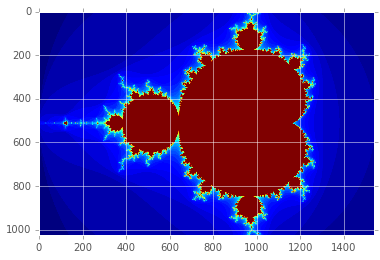

In [35]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print "Mandelbrot created on CPU in %f s" % dt
plt.imshow(gimage);

#### Numba

In [36]:
# Reuse regular function on GUO by using jit decorator
# This is using the jit decorator as a function (to avoid copying and pasting code)
import numba
mandel_numba = numba.jit(restype=uint32, argtypes=[float32, float32, uint32])(mandel)

In [37]:
@numba.jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color  

Mandelbrot created on CPU in 0.339179 s


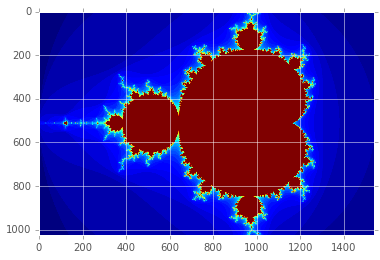

In [38]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print "Mandelbrot created on CPU in %f s" % dt
plt.imshow(gimage);

#### CUDA 

In [39]:
# Reuse regular function on GUO by using jit decorator
mandel_gpu = cuda.jit(restype=uint32, argtypes=[float32, float32, uint32], device=True)(mandel)

In [40]:
@cuda.jit(argtypes=[float32, float32, float32, float32, uint8[:,:], uint32])
def create_fractal_kernel(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x # stride in x
    gridY = cuda.gridDim.y * cuda.blockDim.y # stride in y
    
    for x in range(startX, width, gridX):
        real = xmin + x*pixel_size_x
        for y in range(startY, height, gridY):
            imag = ymin + y*pixel_size_y
            color = mandel_gpu(real, imag, iters)
            image[y, x]  = color    

Mandelbrot created on GPU in 0.010257 s


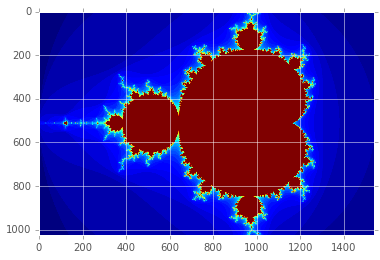

In [41]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
blockdim = (32, 8)
griddim = (32, 16)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
d_image = cuda.to_device(gimage)
create_fractal_kernel[griddim, blockdim](xmin, xmax, ymin, ymax, d_image, iters)
d_image.to_host()
dt = timer() - start

print "Mandelbrot created on GPU in %f s" % dt
plt.imshow(gimage);

### Using CUDA liraries

See documentation at <http://docs.continuum.io/numbapro/cudalib.html>

#### Matrix multiplication wiht `cublas`

In [42]:
import numbapro.cudalib.cublas as cublas 
blas = cublas.Blas()

n =100
A = np.random.random((n, n)).astype(np.float32)
B = np.random.random((n, n)).astype(np.float32)
C = np.zeros_like(A, order='F')

blas.gemm('T', 'T', n, n, n, 1.0, A, B, 1.0, C)

assert(np.allclose(np.dot(A, B), C))

#### Random numbers with `curand`

In [43]:
from numbapro.cudalib import curand
prng = curand.PRNG()
prng.seed = 123

@vectorize('float32(float32)', target='gpu')
def shift(x):
    return x*2 - 1

n = 1e7
x = np.empty(n*2).astype(np.float32)
prng.uniform(x)
r = shift(x).reshape((n, 2))
pi_hat =4*(r[:,0]**2 + r[:,1]**2 < 1).sum()/n
pi_hat

3.1409

#### FFT and IFFT

In [44]:
import numbapro.cudalib.cufft as cufft 

In [45]:
num = 4
v = np.random.normal(0, 1, (num, 2))
z = v[:,0] + 1j*v[:,1]
print "{:<20}".format('Original'), z

x_gpu = np.zeros(num, dtype='complex')
cufft.fft(z, x_gpu)
print "{:<20}".format('CUDA FFT'), x_gpu

x_cpu = np.fft.fft(z)
print "{:<20}".format('CPU  FFT'), x_cpu

# NVidia IFFT returns unnormalzied results
cufft.ifft(x_gpu, z) 
print "{:<20}".format('CUDA IFFT'), z/num

x_cpu = np.fft.ifft(x_cpu)
print "{:<20}".format('CPU  IFFT'), x_cpu

Original             [ 0.8236-0.564j   0.0743-1.0426j  0.3215+1.0885j -0.7250-1.7846j]
CUDA FFT             [ 0.4944-2.3028j  1.2440-2.4518j  1.7958+3.3518j -0.2400-0.853j ]
CPU  FFT             [ 0.4944-2.3028j  1.2440-2.4518j  1.7958+3.3518j -0.2400-0.853j ]
CUDA IFFT            [ 0.8236-0.564j   0.0743-1.0426j  0.3215+1.0885j -0.7250-1.7846j]
CPU  IFFT            [ 0.8236-0.564j   0.0743-1.0426j  0.3215+1.0885j -0.7250-1.7846j]


More examples
----

### Navie matrix multiply

* Grids, blocks and threads
* Maximum size of block is 512 or 1024 threads, depending on GPU
* Get around by using many blocks of threads to partition matrix computataions
* Full matrix divided into tiles
* See Figure below

In [46]:
Image(url="http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/matrix-multiplication-with-shared-memory.png")

In [47]:
x1 = np.random.random((4,4))
x2 = np.random.random((4,4))
np.dot(x1, x2).shape

(4, 4)

#### Kernel function (no shared memory)

In [48]:
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], int32)')
def cu_matmul(a, b, c, n):
    x, y = cuda.grid(2)
    
    if (x >= n) or (y >= n):
        return
    
    c[x, y] = 0
    for i in range(n):
        c[x, y] +=  a[x, i] * b[i, y]

In [49]:
tpb = device.WARP_SIZE
n = 400
bpg = (n+tpb-1)//tpb
grid_dim = (bpg, bpg)
block_dim = (tpb, tpb)

A = np.random.random((n, n)).astype(np.float32)
B = np.random.random((n, n)).astype(np.float32)
C = np.empty((n, n), dtype=np.float32)
cu_matmul[grid_dim, block_dim](A, B, C, n)
assert(np.allclose(np.dot(A, B), C))

### Matrix multiply with shared memory

Memmory access speed
* Local to thread
* Shared among block of threads
* Global (much slower than shared) 
* Host

Want to push memory access as close to threads as possible. In practice, the challenge is usually to structure the program in such a way that shared mmeory use is optimized.

In [50]:
Image(url="http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/memory-hierarchy.png")

#### Using shared mmeory by using tiling to exploit locality

In [51]:
Image(url="http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/matrix-multiplication-with-shared-memory.png")

#### Kernel function (with shared memory)

In [52]:
tpb = device.WARP_SIZE
block_dim = (tpb, tpb)

@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], int32, int32, int32)')
def cu_matmul_sm(A, B, C, n, tpb, bpg):
    # decalre shared memory
    sA = cuda.shared.array(shape=block_dim, dtype=float32)
    sB = cuda.shared.array(shape=block_dim, dtype=float32)
    
    # we now need the thread ID within a block as well as the global thread ID
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    x, y = cuda.grid(2)    
    
    # pefort partial operations in block-szied tiles
    # saving intermediate values in an accumulator variable
    acc = 0.0
    for i in range(bpg):
        # Stage 1: Prefil shared memory with current block from matrix A and matrix B
        sA[tx, ty] = A[x, ty + i * tpb]
        sB[tx, ty] = B[tx + i * tpb, y]
        
        # Block calculations till shared mmeory is filled
        cuda.syncthreads()
        
        # Stage 2: Compute partial dot product and add to accumulator
        if x < n and y < n:
            for j in range(tpb):
                acc += sA[tx, j] * sB[j, ty]
                
        # Blcok until all threads have completed calcuaiton before next loop iteration
        cuda.syncthreads()
        
    # Put accumulated dot product into output matrix
    if x < n and y < n:
        C[x, y] = acc

In [53]:
k = 32
n = tpb * k # n must be multiple of tpb because shared memory is not initialized to zero
bpg = n//tpb
grid_dim = (bpg, bpg)

A = np.random.random((n, n)).astype(np.float32)
B = np.random.random((n, n)).astype(np.float32)
C = np.empty((n, n), dtype=np.float32)
cu_matmul_sm[grid_dim, block_dim](A, B, C, n, tpb, bpg)
assert(np.allclose(np.dot(A, B), C))

#### Benchmark

In [54]:

k = 8
n = tpb * k
bpg = n//tpb
grid_dim = (bpg, bpg)

# Prepare data on the CPU
A = np.array(np.random.random((n, n)), dtype=np.float32)
B = np.array(np.random.random((n, n)), dtype=np.float32)
C = np.zeros_like(A)

print "N = %d x %d" % (n, n)

# Prepare data on the GPU
dA = cuda.to_device(A)
dB = cuda.to_device(B)
dC = cuda.to_device(C) # device_array_like(A)

# Time numpy version
s = timer()
np_ans = np.dot(A, B)
e = timer()
t = e - s

# Time the unoptimized version
s = timer()
cu_matmul[grid_dim, block_dim](dA, dB, dC, n)
cuda.synchronize()
e = timer()
unopt_ans = dC.copy_to_host()
tcuda_unopt = e - s

# Time the shared memory version
s = timer()
cu_matmul_sm[grid_dim, block_dim](dA, dB, dC, n, tpb, bpg)
cuda.synchronize()
e = timer()
opt_ans = dC.copy_to_host()
tcuda_opt = e - s

# Time for CuBLAS version
s = timer()
blas.gemm('T', 'T', n, n, n, 1.0, A, B, 1.0, C) # A, B not in fortran order so need for transpose
e = timer()
blas_ans = dC.copy_to_host()
tcuda_blas = e - s

print "Using numpy.dot:", "%.2f" % t, "s"
print "Without shared memory:", "%.2f" % tcuda_unopt, "s"
print "With shared memory:", "%.2f" % tcuda_opt, "s"
print "Using CuBLAS:", "%.2f" % tcuda_blas, "s"

N = 256 x 256
Using numpy.dot: 0.00 s
Without shared memory: 0.01 s
With shared memory: 0.00 s
Using CuBLAS: 0.00 s


In [55]:
assert np.allclose(np_ans, unopt_ans)
assert np.allclose(np_ans, opt_ans)
assert np.allclose(np_ans, blas_ans)

In [56]:
%load_ext version_information

In [57]:
%version_information numpy, pandas, numba, numbapro  

Software versions
Python 2.7.9 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 2.2.0
OS Darwin 13.4.0 x86_64 i386 64bit
numpy 1.9.2
pandas 0.14.1
numba 0.17.0
numbapro 0.17.1
Sun Mar 29 19:32:55 2015 EDT